In [34]:
import torch
import matplotlib.pyplot as plt
import numpy as np

In [35]:
from torch import nn
from torchvision import datasets, transforms
from torchvision.transforms import Compose, ToTensor, Normalize
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable

In [36]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_device("cuda")

In [37]:
class my_norm(object):
    def __init__(self, val=255):
        self.val = val

    def __call__(self, tensor):
        return tensor/val

    def __repr__(self):
        return self.__class__.__name__ + "normalizing value = {0}".format(self.val)
    
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

In [38]:
class FeatureCopy(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)
        
    def __getitem__(self, idx):
        image, label = self.dataset[idx]
        return image, image

In [39]:
#custom transformation

transform=Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
    AddGaussianNoise(0., .5)
])

In [40]:
batch_size = 128

train_data = datasets.MNIST(
    root = 'data',
    train = True,                         
    transform = ToTensor(), 
    download = True,  
)
test_data = datasets.MNIST(
    root = 'data', 
    train = False, 
    transform = ToTensor(),
)

In [41]:
#Data for de-noising

train_data = FeatureCopy(train_data)
test_data = FeatureCopy(test_data)

In [42]:
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, generator=torch.Generator("cuda"))
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True, generator=torch.Generator("cuda"))

In [43]:
# class Reshape(nn.Module):
#     def __init__(self, shape):
#         super(Reshape, self).__init__()
#         self.shape = shape
#     def forward(self, x):
#         return x.view(self.shape)

In [44]:
class AutoEncoder(nn.Module):
    def __init__(self, shape=None):
        super(AutoEncoder, self).__init__()
        self.shape = shape
        self.encoder = nn.Sequential(
            # nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=2),
            # nn.ReLU(),
            # nn.MaxPool2d(kernel_size=2),
            # nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=2),
            # nn.ReLU(),
            # nn.MaxPool2d(kernel_size=2),
            nn.Flatten(),
            nn.Linear(784, 256),
            nn.ReLU(),
            nn.Linear(256, 10),
            nn.Sigmoid(),
        )
        self.decoder = nn.Sequential(
            nn.Linear(10, 256),
            nn.ReLU(),
            nn.Linear(256, 784),
            #Reshape(shape)
        )

    def forward(self, x):
        out = self.encoder(x)
        out = self.decoder(out)
        return out


In [45]:
autoencoder = AutoEncoder()

In [46]:
shape = (64, 1, 28, 28)

In [47]:
from torch import optim

loss_func = nn.MSELoss(reduction="mean")
optimizer = optim.Adam(autoencoder.parameters(), lr = 1e-3)

In [48]:
def train(num_epochs, model, loader):
    model.train()
    total_step = len(loader)
    
    for epoch in range(num_epochs):
        with torch.set_grad_enabled(True):
            for i, (images, labels) in enumerate(loader):
    
                x = Variable(images).to(device)   
                y = Variable(labels).to(device)
                
                output = model(x)             
                output = output.view(y.size())
                loss = loss_func(output, y)
                
                optimizer.zero_grad()           
                loss.backward()         
                optimizer.step()                
                
                if (i+1) % 100 == 0:
                    print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                           .format(epoch + 1, num_epochs, i + 1, total_step, loss.item()))


In [49]:
train(num_epochs=5, model=autoencoder, loader=train_dataloader)

Epoch [1/5], Step [100/469], Loss: 0.0436
Epoch [1/5], Step [200/469], Loss: 0.0338
Epoch [1/5], Step [300/469], Loss: 0.0307
Epoch [1/5], Step [400/469], Loss: 0.0319
Epoch [2/5], Step [100/469], Loss: 0.0311
Epoch [2/5], Step [200/469], Loss: 0.0273
Epoch [2/5], Step [300/469], Loss: 0.0255
Epoch [2/5], Step [400/469], Loss: 0.0254
Epoch [3/5], Step [100/469], Loss: 0.0268
Epoch [3/5], Step [200/469], Loss: 0.0266
Epoch [3/5], Step [300/469], Loss: 0.0253
Epoch [3/5], Step [400/469], Loss: 0.0254
Epoch [4/5], Step [100/469], Loss: 0.0244
Epoch [4/5], Step [200/469], Loss: 0.0243
Epoch [4/5], Step [300/469], Loss: 0.0245
Epoch [4/5], Step [400/469], Loss: 0.0233
Epoch [5/5], Step [100/469], Loss: 0.0246
Epoch [5/5], Step [200/469], Loss: 0.0238
Epoch [5/5], Step [300/469], Loss: 0.0244
Epoch [5/5], Step [400/469], Loss: 0.0244


In [50]:
images, labels = next(iter(test_dataloader))
images, labels = images.to(device), labels.to(device)
real = labels[:10]

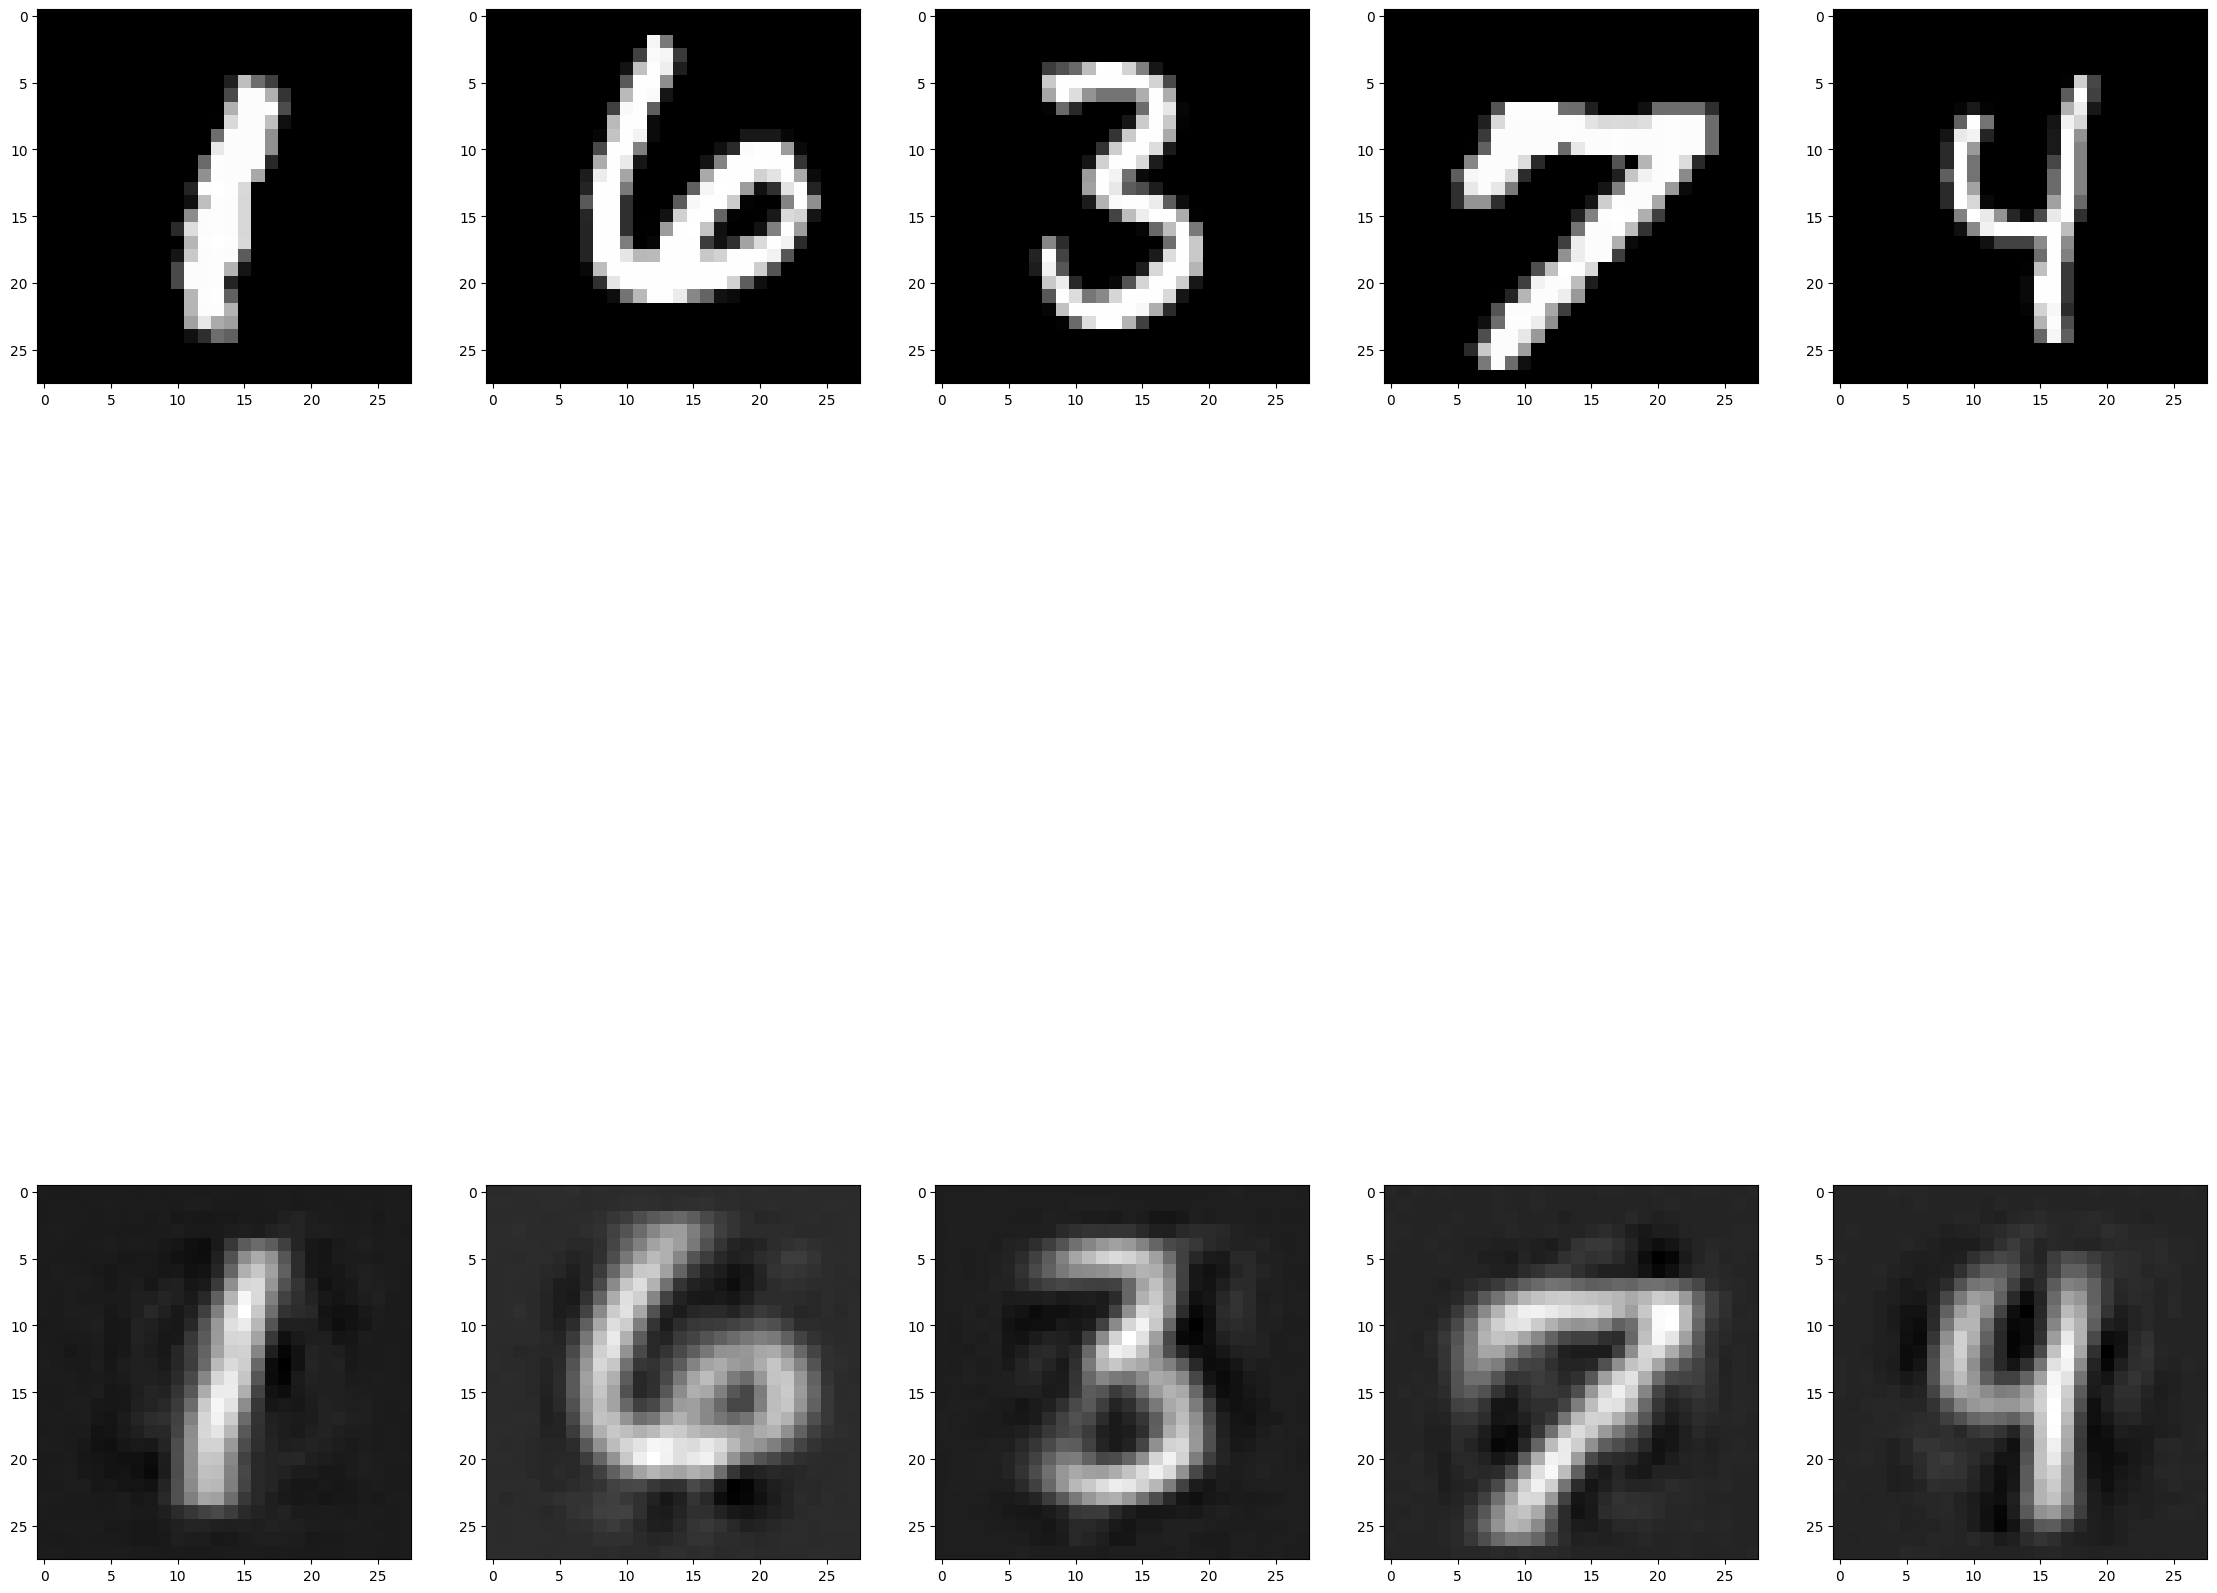

In [51]:
sample0 = (real[0].squeeze()).cpu().numpy()
sample1 = (real[1].squeeze()).cpu().numpy()
sample2 = (real[2].squeeze()).cpu().numpy()
sample3 = (real[3].squeeze()).cpu().numpy()
sample4 = (real[4].squeeze()).cpu().numpy()

fig = plt.figure(figsize=(28, 28))

fig.add_subplot(2, 5, 1)
plt.imshow(sample0, cmap="gray")

fig.add_subplot(2, 5, 2)
plt.imshow(sample1, cmap="gray")

fig.add_subplot(2, 5, 3)
plt.imshow(sample2, cmap="gray")

fig.add_subplot(2, 5, 4)
plt.imshow(sample3, cmap="gray")

fig.add_subplot(2, 5, 5)
plt.imshow(sample4, cmap="gray")

autoencoder.eval()
pred = autoencoder(images[:10].to(device))
pred = pred.view(real.size())

sample_pred0 = pred[0].detach().cpu().numpy().squeeze()
sample_pred1 = pred[1].detach().cpu().numpy().squeeze()
sample_pred2 = pred[2].detach().cpu().numpy().squeeze()
sample_pred3 = pred[3].detach().cpu().numpy().squeeze()
sample_pred4 = pred[4].detach().cpu().numpy().squeeze()

fig.add_subplot(2, 5, 6)
plt.imshow(sample_pred0, cmap="gray")

fig.add_subplot(2, 5, 7)
plt.imshow(sample_pred1, cmap="gray")

fig.add_subplot(2, 5, 8)
plt.imshow(sample_pred2, cmap="gray")

fig.add_subplot(2, 5, 9)
plt.imshow(sample_pred3, cmap="gray")

fig.add_subplot(2, 5, 10)
plt.imshow(sample_pred4, cmap="gray")

plt.show()

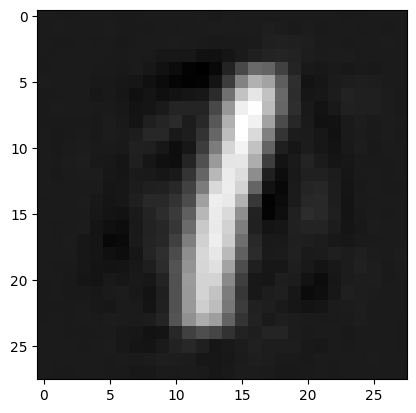

In [52]:
plt.imshow(sample_pred, cmap="gray")
plt.show()

In [53]:
class DecoderOnly(nn.Module):
    def __init__(self, autoencoder):
        super(DecoderOnly, self).__init__()
        self.decoder = autoencoder.decoder

    def forward(self, x):
        out = self.decoder(x)
        return out
        
decoder = DecoderOnly(autoencoder)

In [54]:
class EncoderOnly(nn.Module):
    def __init__(self, autoencoder):
        super(EncoderOnly, self).__init__()
        self.encoder = autoencoder.encoder

    def forward(self, x):
        out = self.encoder(x)
        return out

encoder = EncoderOnly(autoencoder)

In [55]:
encoder(images[0])

tensor([[0.2028, 0.9208, 0.2872, 0.0760, 0.4938, 0.5563, 0.7096, 0.2103, 0.7745,
         0.6847]], device='cuda:0', grad_fn=<SigmoidBackward0>)

In [56]:
for param in decoder.parameters():
    param.data = param.data.double()
decoder = decoder.double()

In [61]:
test_inp = torch.tensor([0.2028, 0.9208, 0.2872, 0.0760, 0.4938, 0.5563, 0.7096, 0.2103, 0.7745,
         0.6847], dtype=torch.float64, device=device)

In [62]:
test_out = decoder(test_inp)

In [63]:
test_out = test_out.view(1, 28, 28)
out_img = test_out[0].detach().cpu().numpy().squeeze()

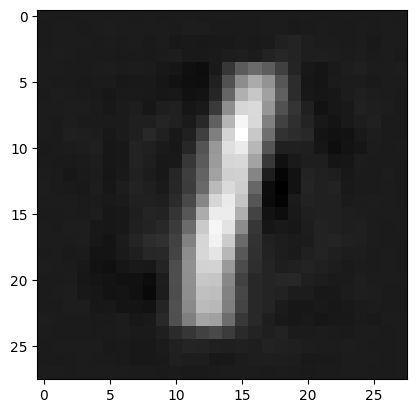

In [64]:
plt.imshow(out_img, cmap="gray")
plt.show()